# Oxygen corrections applied to delayed-mode data

This notebook performs analysis and correction of oxygen data from the following C-PROOF glider deployment:

In [60]:
glider_name = 'dfo-bb046'
deploy_name = f'{glider_name}-20220707'
deploy_prefix = f'./glider/{glider_name}/{deploy_name}/'
ox_corr_dir = deploy_prefix
filepath = 'e:/Glider/data/' # Important for later functions 
openfile = f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_adjusted.nc'
opengridfile = f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_grid_adjusted.nc'
deployfile = f'{deploy_prefix}/deployment.yml'

description = 'Calvert Island Line'
initials = 'AH'

# Oxygen sensor specs and sensor-specific constants
from datetime import date, datetime, timedelta
field = 'oxy' #Determines if we need to convert to phase before applying time lag correction, verify units are in uM (umol/L), options are 'oxy' or 'phase'
optode = 'Rinko' #Which type of sensor is on the glider 'Aanderaa' or 'Rinko'
sn = '0054' #Sensor serial number
calib_date = '20211101' # yyyymmdd
calib_date = datetime.strptime(calib_date, "%Y%m%d")
filt_name = 'Milo' #Type of filter to apply, options are 'Milo' and 'Boxcar'

processing_date = date.today().strftime('%Y%m%d')
processing_protocol = 'C-PROOF_OxygenProcessingReport_v0.2.pdf'

# Import module for loading .md files
from IPython.display import Markdown, display

In [61]:
# Summarize info for report:
print(f'************')
print(f'** {description}:  glider {glider_name}**')
print(f'************')
print(f'* Deployment: {deploy_name}')
print(f'')
print(f'* Optode: {optode}')
print(f'* Using {field} sensor, with serial number: {sn}')
print(f'* Calibration date: {calib_date}')
print(f'* Using {filt_name} filter')
print(f'')
# print(f'* Protocols are detailed in: {processing_protocol}')
print(f'* Processing steps will be saved in: Oxygen_{deploy_name}.html')
# print(f'* Files will be located in: {deploy_prefix}')
print(f'* Processed by {initials}, IOS Data Products team, Ocean Sciences Division, Fisheries and Oceans Canada')
print(f'* Processing date: {processing_date}')

************
** Calvert Island Line:  glider dfo-bb046**
************
* Deployment: dfo-bb046-20220707

* Optode: Rinko
* Using oxy sensor, with serial number: 0054
* Calibration date: 2021-11-01 00:00:00
* Using Milo filter

* Processing steps will be saved in: Oxygen_dfo-bb046-20220707.html
* Processed by AH, IOS Data Products team, Ocean Sciences Division, Fisheries and Oceans Canada
* Processing date: 20250109


# 1.0 Preamble
This document describes dissolved oxygen data processing steps applied to delayed mode data collected using a Rinko ARO-FT-CE dissolved oxygen optode mounted on an Alseamar SeaExplorer autonomous ocean glider. This sensor is mounted in the nose cone of the glider, adjacent to the CTD, and measures oxygen concentration. It has a response time of less than 1 s. Corrections applied use data collected by the CTD on the glider. Note that when converting between oxygen units, potential density is used. 

## 1.1 Set up the processing

The processing steps below are applied to delayed mode data stored in a single netcdf timeseries file created using the Pyglider data processing package (https://github.com/c-proof/pyglider). This data has already undergone CTD sensor corrections. 

The metadata and a detailed report describing the corrections being applied will be made available via the deployment page on the C-PROOF website: **https://cproof.uvic.ca/gliderdata/deployments/dfo-bb046/dfo-bb046-20220707/**

In [62]:
import os
import warnings
warnings.filterwarnings('ignore')
os.chdir("C:/Users/hilborna/Documents/Glider_Data/glider_correction/")

import xarray as xr
import numpy as np
import pathlib

import time 
import tqdm

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import scipy.stats as stats
from scipy.interpolate import interp1d

import pandas as pd
import csv
import seawater
import gsw
import re

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# print(f'Opening: {openfile}')
ds = xr.open_dataset(f'{openfile}')

In [64]:
if field == 'oxy' and optode == 'Rinko' and sn == '0054':
    print(f'Loading coefficients for Rinko sensor, SN {sn}')
    #Rinko sensor 0054 from BB 046 replaced the original (0022) in 2022
    d0 = 1.255222e-4
    d1 = -1.544663e-1
    d2 = 1.892410e-1
    c0 = 2.912402e-3
    c1 = 1.262973e-4
    c2 = 2.710603e-6
    
    Cp = 0.0041 #Calibration coeff for pressure correction, listed on the calibration cert
    
    B0 = -0.00624523 #These don't change
    B1 = -0.00737614
    B2 = -0.01034100
    B3 = -0.00817083
    C0 = -0.000000488682
    sal_ref = 0 #[PSU] This is always the case for Rinko sensors
else:
    print('Verify sensor information and calibration coefficients are correct!')

Loading coefficients for Rinko sensor, SN 0054


# 2.0 Corrections applied to delayed mode data for this mission
This document covers the following steps:
1. Compensate for pressure and salinity effects
2. Convert from concentration in $\mu$mol/L to phase
3. Determine and apply the sensor response time lag correction
4. Convert from phase to concentration in $\mu$mol/L
5. Determine and apply the optode drift correction

## 2.1 Compensate for pressure and salinity effects

The Rinko ARO-FT User's manual states that corrections must be applied for pressure and salinity effects to the dissolved oxygen concentration in 𝜇mol/L (oxygen_concentration).

The pressure compensation factor is estimated as: $p_factor = (|P| / 100) ⋅ Cp + 1$

where P is the pressure from the CTD in dbars, and Cp is the calibration coefficient for pressure correction, listed on the calibration certificate for each sensor. 

The salinity compensation factor is estimated as:
$s_{}factor = e^{[S ⋅ (B0 + B1 ⋅ Ts + B2 ⋅ Ts^{2} + B3 ⋅ Ts^{3}) + C0 ⋅ S2]}$

where S is the fully corrected salinity from the CTD in PSU, B0 to B3 and C0 are coefficients specified in the Rinko manual, Ts is the scaled temperature: $Ts = ln[(298.15 - T) / (273.15 + T)]$; and T is the temperature from the CTD in degrees Celsius. 

Unlike the Aanderaa sensors, the Rinko optodes apparently do not have an internal reference salinity. The manual states “Note that the physical value output of the instrument does not consider salinity and/or pressure.” This is equivalent to sal_ref = 0 for the purposes of the salinity compensation correction above. 

Then compensated oxygen concentration is calculated: 
$oxygen_{}comp = oxygen_{}uncomp ⋅ s_{}factor ⋅ p_{}factor$

The units of oxygen_comp are 𝜇mol/L. 


In [65]:
# First step: Salinity- and pressure- compensated oxygen corrections

# pressure compensation, with pressure in dbars
p_factor = 0.01*abs(ds.pressure)*Cp + 1

# salinity compensation, using temperature from the CTD
Ts = np.log((298.15-ds.temperature)/(273.15+ds.temperature))
s_factor = np.exp((ds.salinity - sal_ref) * (B0 + B1 * Ts + B2 * Ts * Ts + B3 * Ts * Ts * Ts) + C0 * (ds.salinity * ds.salinity - sal_ref * sal_ref))

# compensated oxygen
oxygen_comp = ds.oxygen_concentration * s_factor * p_factor  # uM

# set any negative values to zero
oxygen_comp[oxygen_comp < 0] = 0

Top left: Some of the oxygen profiles, without corrections. Top right: Difference between compensated and uncompensated oxygen for the first part of the mission. Bottom left: uncompensated and compensated (red) oxygen by depth (pressure). Bottom right: Salinity vs oxygen, showing compensated and uncompensated values for the first part of the glider mission.


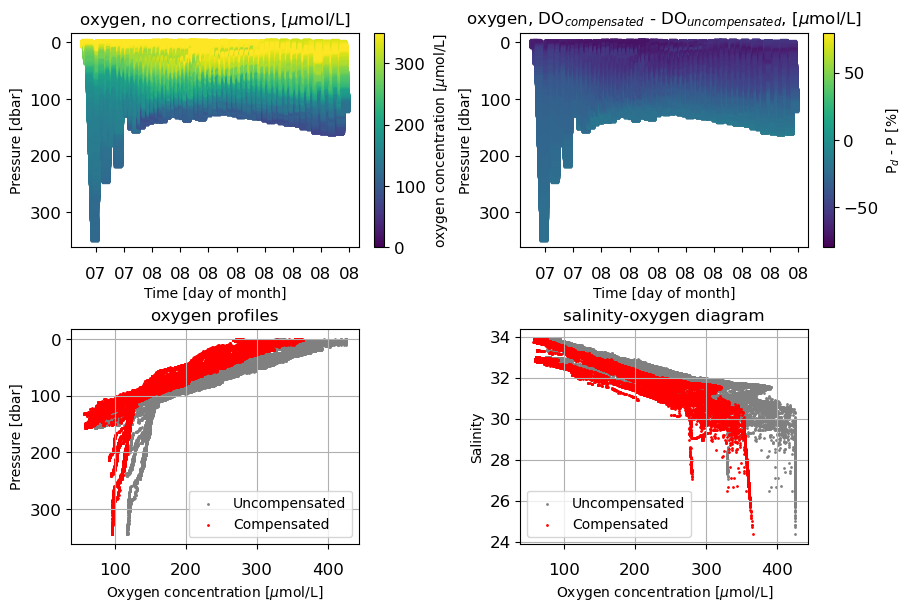

In [66]:
#Visualizing the corrections
fld = oxygen_comp[0:min([len(oxygen_comp), 100000])]
dp = ds.pressure[0:min([len(fld), 100000])]
tm = ds.time[0:min([len(fld), 100000])]
fld_orig = ds.oxygen_concentration[0:min([len(fld), 100000])]
sal = ds.salinity[0:min([len(fld), 100000])]
v1min=0
v1max=350
v2min=-0.5
v2max=0.5

fig, ax = plt.subplots(2,2,constrained_layout=True, 
                            figsize=(9, 6))
ax0 = ax[0,0]
sc = ax0.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld_orig[~np.isnan(fld)], marker='s', vmin=0, vmax=350, rasterized=True)
cb0 = plt.colorbar(sc, ax=ax0, orientation='vertical', label='oxygen concentration [$\mu$mol/L]')
cb0.ax.tick_params(labelsize=12)
ax0.set_title('oxygen, no corrections, [$\mu$mol/L]')
ax0.set_xlabel('Time [day of month]')
ax0.set_ylabel('Pressure [dbar]')
ax0.invert_yaxis()
ax0.tick_params(labelsize=12)
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax0.xaxis.set_tick_params(which='major', pad=10)

ax1 = ax[0,1]
sc = ax1.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld[~np.isnan(fld)]-fld_orig[~np.isnan(fld)], marker='s', vmin=-80, vmax=80, rasterized=True) 
cb1 = plt.colorbar(sc, ax=ax1, orientation='vertical', label='P$_d$ - P [%]')
cb1.ax.tick_params(labelsize=12)
ax1.set_title('oxygen, DO$_{compensated}$ - DO$_{uncompensated}$, [$\mu$mol/L]')
ax1.set_xlabel('Time [day of month]')
ax1.set_ylabel('Pressure [dbar]')
ax1.invert_yaxis()
ax1.tick_params(labelsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax1.xaxis.set_tick_params(which='major', pad=10)

ax2 = ax[1,0]
ax2.grid()
ax2.scatter(fld_orig[~np.isnan(fld)], dp[~np.isnan(fld)],  s=1, c='gray', label='Uncompensated', rasterized=True)
sc = ax2.scatter(fld[~np.isnan(fld)], dp[~np.isnan(fld)], s=1, c='r', label='Compensated', rasterized=True)
ax2.legend()
ax2.set_title('oxygen profiles')
ax2.set_xlabel('Oxygen concentration [$\mu$mol/L]')
ax2.set_ylabel('Pressure [dbar]')
ax2.invert_yaxis()
ax2.tick_params(labelsize=12)
ax2.xaxis.set_tick_params(which='major', pad=10)

ax3 = ax[1,1]
ax3.grid()
ax3.scatter(fld_orig[~np.isnan(fld)], sal[~np.isnan(fld)], s=1, c='gray', label='Uncompensated', rasterized=True)
sc = ax3.scatter(fld[~np.isnan(fld)], sal[~np.isnan(fld)], s=1, c='r', label='Compensated', rasterized=True)
ax3.legend()
ax3.set_title('salinity-oxygen diagram')
ax3.set_xlabel('Oxygen concentration [$\mu$mol/L]')
ax3.set_ylabel('Salinity')
ax3.tick_params(labelsize=12)
ax3.xaxis.set_tick_params(which='major', pad=10)

print("Top left: Some of the oxygen profiles, without corrections. Top right: Difference between compensated and uncompensated oxygen for the first part of the mission. Bottom left: uncompensated and compensated (red) oxygen by depth (pressure). Bottom right: Salinity vs oxygen, showing compensated and uncompensated values for the first part of the glider mission.")

Mean percent difference: -18.39 +/- 0.96
Left: Histogram of oxygen values before and after compensation. Right: Histogram of the change in oxygen before and after compensation, for the first part of the mission.


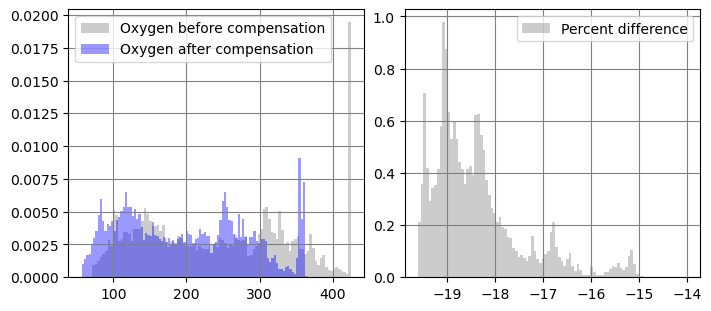

In [67]:
#compensated:
# fld
#uncompensated:
# fld_orig
fig, axs = plt.subplots(1,2,figsize=(7,3), constrained_layout=True)

ax=axs[0]
ax.hist(fld_orig, 100, alpha = 0.4, density=True, histtype='bar', 
                  color='gray', label='Oxygen before compensation')
ax.hist(fld, 100, alpha = 0.4, density=True, histtype='bar', 
                  color='blue', label='Oxygen after compensation')
ax.legend(prop={'size': 10})
ax.grid(color='0.5')

ax=axs[1]
ax.hist((fld-fld_orig)/fld_orig*100, 100, alpha = 0.4, density=True, histtype='bar', 
                  color='gray', label='Percent difference')
ax.legend(prop={'size': 10})
ax.grid(color='0.5')

test = (fld-fld_orig)/fld_orig*100
print(f'Mean percent difference: {round(np.nanmean(test),2)} +/- {round(np.nanstd(test),2)}');

print("Left: Histogram of oxygen values before and after compensation. Right: Histogram of the change in oxygen before and after compensation, for the first part of the mission.")

## 2.2 Convert oxygen concentration in $\mu$mol L$^{-1}$ to phase

The uncalibrated phase (Phase) is the difference between the phase obtained when the foil is excited by Blue light and by Red light. These hexadecimal values are referred to as ‘AD values’, as opposed to calculated temperature and dissolved oxygen concentration, which are referred to as ‘Physical values’. 

The time response correction (5.1) is applied to the AD value of dissolved oxygen (AD value of DO), which is functionally equivalent to the calibrated phase. Then the dissolved oxygen concentration in 𝜇mol/L is calculated using the Stern-Volmer relationship proposed by Uchida et al., 2010:

$$ DO [{\mu}mol/L] = {((1 + d0 ⋅ T)/(d1 + d2 ⋅ N + d3 ⋅ t + d4 ⋅ t ⋅ N))^{e0} - 1} ⋅ {1/(c0 + c1⋅T + c2⋅T^2)} $$

where calibration coefficients $c0$, $d0$, $e0$ etc. are printed on the calibration certificate for that sensor, $T$ is temperature, and $N$ is the AD value of $DO/10000$. Typically $e0 = 1$ and $d3 = d4 = 0$, so that we do not require values of t, the LED accumulation time [s]. 
 
Our sensors are normally set to output dissolved oxygen concentration in 𝜇mol/L (oxygen_concentration), which is then converted to calibrated phase (AD value of DO) using the temperature measurement from the oxygen sensor, the time response correction is applied, and then the resulting field is converted back to DO[𝜇mol/L] using the fully corrected temperature measurement from the CTD. 

In [68]:
# Second step: Convert from oxygen concentration to phase if phase not available

# For Rinkos, we can use the relation from Uchida et al., 2010
# P0/Pc = (1 + d0*T)/(d1 + d2*Pr), where d0 = c4/c3, d1 = c5/c3, and d2 = c6/c3.

Ksv = c0 + (c1 * ds.temperature) + (c2 * ds.temperature * ds.temperature)
oxygen_phase = (((1 + (d0 * ds.temperature)) / ((oxygen_comp * Ksv) + 1)) - d1) / d2
field = 'phase'

Oxygen in phase (left), after conversion from concentration (right):


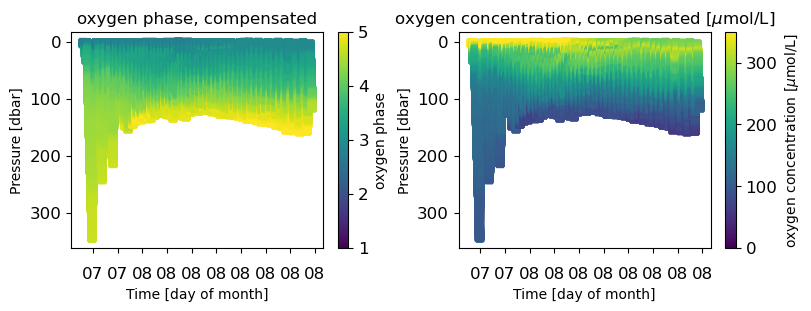

In [72]:
#Visualizing the corrections
fld = oxygen_phase[0:min([len(oxygen_phase), 100000])]
fld_orig = oxygen_comp[0:min([len(fld), 100000])]
dp = ds.pressure[0:min([len(fld), 100000])]
tm = ds.time[0:min([len(fld), 100000])]
sal = ds.salinity[0:min([len(fld), 100000])]

fig, ax = plt.subplots(1,2,constrained_layout=True, 
                            figsize=(8, 3))
ax0 = ax[0]
sc = ax0.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld[~np.isnan(fld)], marker='s', vmin=1, vmax=5, rasterized=True)
cb0 = plt.colorbar(sc, ax=ax0, orientation='vertical', label='oxygen phase')
cb0.ax.tick_params(labelsize=12)
ax0.set_title('oxygen phase, compensated')
ax0.set_xlabel('Time [day of month]')
ax0.set_ylabel('Pressure [dbar]')
ax0.invert_yaxis()
ax0.tick_params(labelsize=12)
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax0.xaxis.set_tick_params(which='major', pad=10)

ax1 = ax[1]
sc = ax1.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld_orig[~np.isnan(fld)], marker='s', vmin=0, vmax=350, rasterized=True)
cb1 = plt.colorbar(sc, ax=ax1, orientation='vertical', label='oxygen concentration [$\mu$mol/L]')
cb1.ax.tick_params(labelsize=12)
ax1.set_title('oxygen concentration, compensated [$\mu$mol/L]')
ax1.set_xlabel('Time [day of month]')
ax1.set_ylabel('Pressure [dbar]')
ax1.invert_yaxis()
ax1.tick_params(labelsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax1.xaxis.set_tick_params(which='major', pad=10)

print('Oxygen in phase (left), after conversion from concentration (right):')

## 2.3 Sensor reponse time lag correction

### Determine the response time lag: 
The time response correction is applied to the calibrated optode phase (AD value of DO for Rinko sensors) to account for the slow sensor response time relative to the diving rate of the glider. 

Following Nicholson et al., 2008 and Howatt et al., 2018, a response time constant $\tau$ is determined by minimizing the error between all measured upcast values vs. all measured downcast values. A first-order lag correction is determined by calculating $\tau$ as in Fofonoff et al., 1974 based on the equation:

$$Phase_{true} = Phase_{measured} + \tau ⋅ d/dt ⋅ Phase_{measured}$$ where $Phase$ is the calibrated optode phase, ‘true’ is the true value and ‘measured’ is the measured value, and $d/dt$ indicates a first derivative w.r.t. time during a given upcast or downcast. Derivatives are calculated using a centered finite difference scheme after successive upcasts and downcasts are interpolated onto the same depth grid. To avoid large derivatives caused by points at the start and end of individual profiles, any $dt$ value greater than one standard deviation from the mean is excluded from the calculation. 

Then a least squares linear regression is performed on the following equation:
$$Phase_{measured}^{upcast} -Phase_{measured}^{downcast} = - \tau ⋅ (d/dt ⋅ Phase_{measured}^{upcast} - d/dt ⋅ Phase_{measured}^{downcast})$$ 

which assumes that successive upcasts and downcasts are identical.

Expected ranges for the response time constant for each type of sensor are provided in Bittig et al., 2014. For our Rinko sensors, the calculated value of $\tau$ is expected to fall in the range 1 to 3 seconds. If the calculated response time constant falls outside of these ranges, manual inspection of the mission data is required to determine the cause. 

Given the rapid response time of Rinko sensors, it is expected that $\tau$ may be too small to necessitate applying a time lag correction. We verify this below. 

In [70]:
# Third step: Compare upcasts and downcasts to estimate time lag tau
# This step calculates the sensor response time lag using a least squares 
# regression on the whole timeseries. 

if field == 'phase':
    field_oxy = oxygen_phase
else:
    field_oxy = ds.oxygen_concentration

dz_mean = np.nanmean(np.abs(np.diff(ds.depth))) # average distance between samples in depth 

# calculate tau based on whole timeseries

#set up fields
upcast_field_interp = np.array([])
downcast_field_interp = np.array([])
upcast_time_interp = np.array([])#.astype("datetime64[s]")
downcast_time_interp = np.array([])#.astype("datetime64[s]")
z_full = np.array([])
i_bad = np.array([])

#set up variables we'll need 
dst = ds.copy()
dst['field_oxy'] = field_oxy #oxygen data
dst['pind'] = dst['pind'].astype('int') #profile index
dst['profile_direction'] = dst['profile_direction'].astype('int') #profile direction

#group the upcasts and downcasts
ds_group = dst.groupby('profile_direction')
upcasts = ds_group[-1]
downcasts = ds_group[1]
print('Grouping upcasts and downcasts, stand by.')

#ensure each downcast has a matching upcast
downcast_index = np.unique(downcasts.profile_index[np.isin(downcasts.profile_index, 
                                                           upcasts.profile_index-1, assume_unique=False)]).astype('int')
print('Grouping upcasts and downcasts complete.')

Grouping upcasts and downcasts, stand by.
Grouping upcasts and downcasts complete.


In [71]:
#Interpolate the upcasts and downcasts to a consistent depth grid

print('Interpolating fields.')
for i in tqdm.tqdm(downcast_index):
    p=i
    dive_ind = np.where(downcasts.profile_index==p) #index of the downcast
    downcast_field = downcasts.field_oxy[dive_ind] #oxygen for the downcast
    downcast_z = downcasts.depth[dive_ind] #depth for the downcast
    downcast_time = downcasts.time[dive_ind] #time for the downcast

    # upcast
    climb_ind = np.where(upcasts.profile_index==p+1) #index of the upcast
    upcast_field = upcasts.field_oxy[climb_ind] #oxygen for the upcast
    upcast_z = upcasts.depth[climb_ind] #depth for the upcast
    upcast_time = upcasts.time[climb_ind] #time for the upcast

    # new depth array
    z_target = np.arange(np.nanmax([downcast_z[0], upcast_z[-1]]), np.nanmin([downcast_z[-1], upcast_z[0]]), dz_mean)

    try:
        # getting rid of any repeats in the depth
        upcast_z,I,_ = np.unique(upcast_z, return_index=True, return_counts=True) 
        upcast_field = upcast_field[I]
        upcast_time = upcast_time[I]
        downcast_z,I,_ = np.unique(downcast_z, return_index=True, return_counts=True)
        downcast_field = downcast_field[I]
        downcast_time = downcast_time[I]

        # interpolating upast and downcast to same depth grid
        upcast_field_interp = np.append(upcast_field_interp, np.interp(z_target, upcast_z[~np.isnan(upcast_z)], upcast_field[~np.isnan(upcast_z)]))
        downcast_field_interp = np.append(downcast_field_interp, np.interp(z_target, downcast_z[~np.isnan(downcast_z)], downcast_field[~np.isnan(downcast_z)]))

        # interpolate time to same grid            
        var_non_nan = upcast_time.values[~np.isnan(upcast_z)].astype("datetime64[s]")
        us_since_1970 = (var_non_nan - np.datetime64("1970-01-01").astype("datetime64[s]")).astype(np.int64) 
        time_int = np.interp(z_target, upcast_z[~np.isnan(upcast_z)], us_since_1970)
        upcast_time_interp = np.append(upcast_time_interp, time_int)          

        var_non_nan = downcast_time.values[~np.isnan(downcast_z)].astype("datetime64[s]")
        us_since_1970 = (var_non_nan - np.datetime64("1970-01-01").astype("datetime64[s]")).astype(np.int64)
        time_int = np.interp(z_target, downcast_z[~np.isnan(downcast_z)], us_since_1970)
        downcast_time_interp = np.append(downcast_time_interp, time_int)           

        # depth array to go with timeseries
        z_full = np.append(z_full, z_target)

    except Exception as e:
        raise e
        i_bad = np.append(i_bad, i)

        #filling bad tries with NaN
        upcast_field_interp = np.append(upcast_field_interp, np.nan*np.zeros(len(z_target)))
        downcast_field_interp = np.append(downcast_field_interp, np.nan*np.zeros(len(z_target)))

        upcast_time_interp = np.append(upcast_time_interp, np.nan*np.zeros(len(z_target)))
        downcast_time_interp = np.append(downcast_time_interp, np.nan*np.zeros(len(z_target)))

        z_full = np.append(z_full, z_target)


Interpolating fields.


100%|████████████████████████████████████████████████████████████████████████████████| 445/445 [00:07<00:00, 61.31it/s]


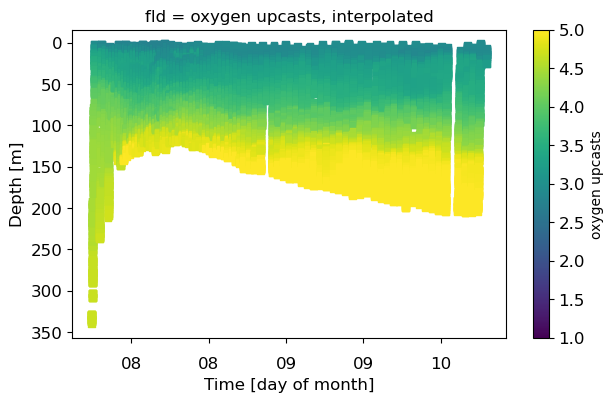

In [73]:
#Quick visualization to ensure interpolated fields look reasonable

fld = upcast_field_interp[:min(len(ds['oxygen_concentration']), 100000)]
dp = z_full[0:min([len(ds['oxygen_concentration']), 100000])]
tm = upcast_time_interp[0:min([len(ds['oxygen_concentration']), 100000])].astype("timedelta64[s]") + np.datetime64("1970-01-01").astype("datetime64[s]")

fig, ax = plt.subplots(figsize=[7,4])
vmin = 1
vmax = 5
sc = ax.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld[~np.isnan(fld)], marker='s', cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True)
cb = plt.colorbar(sc, ax=ax, orientation='vertical', label='oxygen upcasts')
cb.ax.tick_params(labelsize=12)
ax.set_title('fld = oxygen upcasts, interpolated')
ax.set_xlabel('Time [day of month]',fontsize=12)
ax.set_ylabel('Depth [m]',fontsize=12)
ax.invert_yaxis()
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_tick_params(which='major', pad=10)
plt.show()

Now we use the upcasts and downcasts that have been interpolated to a regular depth grid to estimate $\tau$ using least-squares regression applied to the entire time series. 

In [74]:
# Determining tau from least-squares regression
up_field = upcast_field_interp.copy()
dn_field = downcast_field_interp.copy()

# Mask out bad data points with very small or very large dt values using a threshold
# don't want to include samples spaced apart by more than one standard deviation from the mean dt 
# shouldn't have any samples with less than 0.1 secs between them

#Upcasts
upcast_time_secs = upcast_time_interp
thrs = np.abs(np.gradient(upcast_time_secs)) > (np.nanmean(np.abs(np.gradient(upcast_time_secs))) + 
                                                np.nanstd(np.abs(np.gradient(upcast_time_secs))))
tlow = np.abs(np.gradient(upcast_time_secs)) < 0.1 
up_field[thrs] = np.nan
up_field[tlow] = np.nan

#Downcasts
downcast_time_secs = downcast_time_interp
thrs = np.abs(np.gradient(downcast_time_secs)) > (np.nanmean(np.abs(np.gradient(downcast_time_secs))) + 
                                                  np.nanstd(np.abs(np.gradient(downcast_time_secs))))
tlow = np.abs(np.gradient(downcast_time_secs)) < 0.1 
dn_field[thrs] = np.nan
dn_field[tlow] = np.nan

# Centered difference derivative wrt time
ind = ((~np.isnan(up_field)) & (~np.isnan(dn_field))).astype("bool") #find NaN values
dFdt_upcast = np.gradient(up_field[ind], upcast_time_secs[ind], edge_order=2)
dFdt_downcast = np.gradient(dn_field[ind], downcast_time_secs[ind], edge_order=2)

# Regression to find tau
ind_fit = ((~np.isnan(up_field[ind])) & (~np.isnan(dn_field[ind])) & (~np.isnan(dFdt_upcast)) & (~np.isnan(dFdt_downcast))).astype("bool")
y = up_field[ind][ind_fit] - dn_field[ind][ind_fit]
print("****")
print(f"mean phase diff between up and downcasts: {round(np.nanmean(y),3)} +/- {round(np.nanstd(y),3)}")
print("****")
x = dFdt_upcast[ind_fit] - dFdt_downcast[ind_fit]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

tau = -slope
tau_99int = 2.58*std_err #The 99th percentile significance

print('Sensor response lag coefficient [in seconds] tau =', round(tau,3))
print('99th percentile significance =', round(tau_99int,3))
print('R-value for the linear regression =', round(r_value,3))

****
mean phase diff between up and downcasts: 0.014 +/- 0.073
****
Sensor response lag coefficient [in seconds] tau = 0.447
99th percentile significance = 0.176
R-value for the linear regression = -0.056


Phase difference between up and downcasts, compared with the up-down difference of its first derivative. Phase difference vs d/dt (left), shown with histogram of d/dt values (middle) and difference values (right):


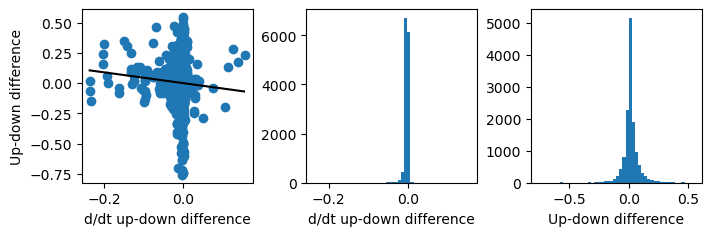

In [81]:
X = np.arange(np.nanmin(x), np.nanmax(x), 0.01) #Used for plotting
# print(X)
Y = np.polyval([slope, 0], X)

fig, ax = plt.subplots(1,3,constrained_layout=True, 
                            figsize=(7, 2.25))
ax[0].scatter(x,y)
ax[0].plot(X,Y, 'k-')
ax[0].set_xlabel(xlabel = 'd/dt up-down difference');
ax[0].set_ylabel(ylabel = 'Up-down difference');

ax[1].hist(x, 50)
ax[1].set_xlabel(xlabel = 'd/dt up-down difference');

ax[2].hist(y, 50)
ax[2].set_xlabel(xlabel = 'Up-down difference');

print('Phase difference between up and downcasts, compared with the up-down difference of its first derivative. Phase difference vs d/dt (left), shown with histogram of d/dt values (middle) and difference values (right):')

### Applying the sensor response time lag correction:

The value of $\tau$ is small as expected, given the 1s response time of the sensor. We note that the least squares fit had a relatively low R-value, suggesting that the upcasts and downcasts were not offset by a consistent amount throughout the time series. Given this, and the small offset, **we elect not to apply a sensor reponse time lag correction**. This choice additionally avoids applying the smoothing and filter required for this correction, better preserving the signals in the data. 

Oxygen concentration for up and downcasts, shown against presssure (left) and adjusted salinity (right):


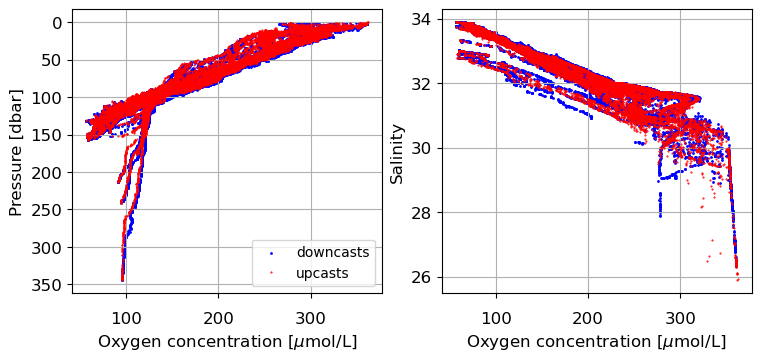

In [82]:
#Confirm the upcasts and downcasts are not offset by a significant amount

fld = oxygen_comp[0:min([len(oxygen_comp), 100000])]
dp = ds.pressure[0:min([len(fld), 100000])]
sal = ds.salinity[0:min([len(fld), 100000])]

#Plotting
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(7.5, 3.5))

ax0 = ax[0]
ind = np.where(ds.profile_direction.values[0:min([len(oxygen_comp), 100000])] == 1)[0]
ax0.scatter(fld[ind], dp[ind], s=1, c='b', label='downcasts', rasterized=True)
ind = np.where(ds.profile_direction.values[0:min([len(oxygen_comp), 100000])] == -1)[0]
ax0.plot(fld[ind], dp[ind], 'r.', markersize=1, label='upcasts')
ax0.set_ylabel('Pressure [dbar]',fontsize=12)
ax0.set_xlabel('Oxygen concentration [$\mu$mol/L]',fontsize=12)
ax0.invert_yaxis()
ax0.tick_params(labelsize=12)
ax0.xaxis.set_tick_params(which='major', pad=10)
ax0.grid()
ax0.legend()

ax1 = ax[1]
ind = np.where(ds.profile_direction.values[0:min([len(oxygen_comp), 100000])] == 1)[0]
ax1.scatter(fld[ind], sal[ind], s=1, c='b', label='downcasts', rasterized=True)
ind = np.where(ds.profile_direction.values[0:min([len(oxygen_comp), 100000])] == -1)[0]
ax1.plot(fld[ind], sal[ind], 'r.', markersize=1, label='upcasts')
ax1.set_ylabel('Salinity',fontsize=12)
ax1.set_xlabel('Oxygen concentration [$\mu$mol/L]',fontsize=12)
ax1.tick_params(labelsize=12)
ax1.xaxis.set_tick_params(which='major', pad=10)
ax1.grid()

print('Oxygen concentration for up and downcasts, shown against presssure (left) and adjusted salinity (right):')

## 2.4 Convert from phase to oxygen concentration in $\mu$mol/L

Given that we are not applying a time response correction, we use 'oxygen_comp' (oxygen concentration in $\mu$mol/L) for the next step in the processing.  

In [83]:
oxygen_correct = oxygen_comp

In [84]:
display(Markdown('./docs/OXY_2_Optode_drift.md'))

## 2.5 Optode drift correction

The sensor drift correction is applied to the time-response corrected, compensated dissolved oxygen concentration data 'DO' to account for the tendency of oxygen optodes to drift over time as the sensor ages. Although drift increases as a function of the number of samples collected, sensors tend to drift more quickly during storage than while in the field by about a factor of 10. 

The sensor drift correction attempts to correct for the drift that does occur by comparing the oxygen optode data to a trustworth profile of dissolved oxygen concentration measurements collected nearby in space and time. Ideally, this comparison would be with Winkler titrated bottle samples collected at the same time and location as one of the glider’s dives. In practice, a hierarchy of ‘trustworthy’ data sources is used, within some chosen tolerance for distance and time from the glider’s sampling locations. 

The drift correction itself is a linear adjustment applied to DO\[$\mu$mol/kg\] with slope p1 and intercept p2: 

oxygen_concentration_adjusted \[$\mu$mol/kg\] = p1 DO\[$\mu$mol/kg\] + p2

Following Bittig et al., 2018, the drift is characterized by a reduced sensor response plus a small offset in the opposite direction. The slope should be positive, and within about 10\% of unity. The intercept should be within a few \[$\mu$mol/kg\] of zero and negative. In practice, the correction is determined with the intercept set to zero a priori. We have found that an intercept of zero typically produces better agreement in the near-surface mixed layer and in deep water, the most appropriate segments of the water column for comparison. 

If the slope is too large, the comparison may be rejected. It is expected that the drift for an individual sensor will increase with time (though not linearly). If this is not the case, or if a sudden large increase in drift is detected, the comparison should be re-evaluated and/or the sensor should be examined. 

### Determining optode drift: 

To determine the drift correction, a least-squares fit is performed in density space between all of the suitable comparison profiles and the associated glider optode measurements. The glider profiles to be used are bin-averaged to the densities associated with the oxygen measurements from the comparison profile, with a bin size of +/-0.1 kg/m$^3$ (which can be adjusted higher if needed). The linear least-squares fit is applied to the binned oxygen optode measurements from the glider vs. the measurements from the comparison profile. The associated correlation coefficient for the fit is expected to be above r$^2$ = 0.95, and in practice is often above r$^2$ = 0.99.

Note that **potential density** is used, not in-situ density, since a given volume of water may move vertically by a significant amount due to isopycnal heaving, and we wish to remove this effect from the comparison. The portion of the profiles within the pycnocline is excluded from the comparison by visually identifying a depth at the base of the pycnocline and retaining only data below it, as well as data in the very near surface that will be close to the saturation value. 

The goodness of fit is evaluated by examining the agreement between the deep and shallow drift-corrected glider oxygen measurements with those from the comparison profile. For the shallowest measurements, the saturation value of oxygen at the comparison profile location is calculated and used to provide context for the expected near-surface oxygen concentration values. 

Finally, the linear sensor drift correction is applied to the DO measurements (not to the data binned by density). 

**For this mission**, two comparison profiles are available:
1) A profile of Winkler-titrated bottle samples collected by the Hakai Institute at the time of glider recovery in Hakai Pass, and,
2) A profile using an oxygen sensor on a lowered CTD, also collected by the Hakai Institute at the time of glider recovery.

We examine both these profiles compared to the available glider data. 

Loading in situ data
The bottom depth for the profile is 340.55 metres
CTD cast and bottle sample data shown with depth for salinity (left), temperature (middle), and oxygen (right):


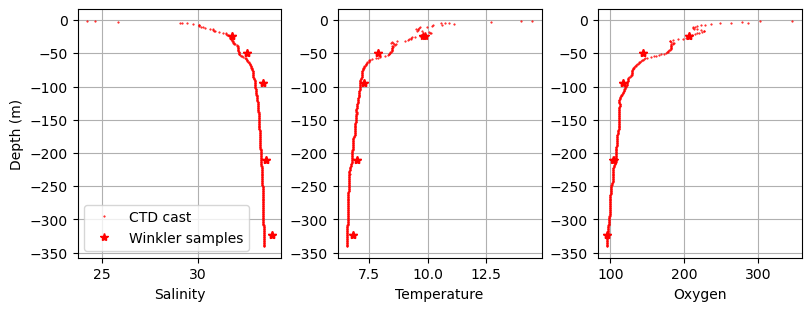

In [89]:
# Sixth step: determine sensor drift by comparison with in-situ Winkler calibrated profiles, in potential density space
# Part 1: LOAD THE COMPARISON DATA

#Comparison with Hakai CTD cast or DFO bottle samples
#For each file:
org = 'hak'; #Specify if file is from Hakai (hak) or DFO (dfo)
print('Loading in situ data')

if org == 'hak':
    df = pd.read_excel(f'{deploy_prefix}/8_binAvg_192732_Winkler.xlsx', sheet_name='Data')
    df.columns = [c.replace(' ', '_') for c in df.columns]
    df.columns = [c.replace('(', '') for c in df.columns]
    df.columns = [c.replace(')', '') for c in df.columns]
    df.columns = [c.replace('/', '') for c in df.columns]
    print(f'The bottom depth for the profile is {round(df.Bottom_depth_m[0],2)} metres')
    #print(list(df))

    lonH = df.Longitude[0]
    latH = df.Latitude[0]
    timeH = df.Measurement_time[0]
    depthH = df.Depth_m

    TH = df.Temperature_deg_C
    SH = df.Salinity_PSU
    PH = df.Pressure_dbar
    OH = df.Dissolved_O2_mLL
    
    df2 = pd.read_excel(f'{deploy_prefix}/8_binAvg_192732_Winkler.xlsx', sheet_name='Winkler')
    df2.columns = [c.replace(' ', '_') for c in df2.columns]
    df2.columns = [c.replace('(', '') for c in df2.columns]
    df2.columns = [c.replace(')', '') for c in df2.columns]
    df2.columns = [c.replace('/', '') for c in df2.columns]
    df2.columns = [c.replace('[', '') for c in df2.columns]
    df2.columns = [c.replace(']', '') for c in df2.columns]

    depthH2 = df2.Actual_Niskin_Depth_m

    TH2 = df2.Sampling_T_deg_C
    SH2 = df2.Sampling_S_PSU
    OH2 = df2.DO_mLL

# print(TH)
# print(SH)
# print(OH)
RH = seawater.eos80.dens(SH, TH, PH)
RH0 = seawater.eos80.dens0(SH, TH)
OH = [val * 44.661 for val in OH]  # Convert units to umol/L

RH02 = seawater.eos80.dens0(SH2, TH2)
OH2 = [val * 44.661 for val in OH2]  # Convert units to umol/L

fig, ax = plt.subplots(1,3,constrained_layout=True, 
                            figsize=(8, 3))
ax[0].plot(SH,depthH*-1,'r.', markersize=1, label='CTD cast');
ax[0].plot(SH2,depthH2*-1,'*r', label='Winkler samples');

ax[1].plot(TH,depthH*-1,'r.', markersize=1, label='CTD cast');
ax[1].plot(TH2,depthH2*-1,'*r', label='Winkler samples');

ax[2].plot(OH,depthH*-1,'r.', markersize=1, label='CTD cast');
ax[2].plot(OH2,depthH2*-1,'*r', label='Winkler samples');

# labels
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_xlabel('Salinity')
ax[1].set_xlabel('Temperature')
ax[2].set_xlabel('Oxygen')
ax[0].set_ylabel('Depth (m)')
ax[0].legend();

print('CTD cast and bottle sample data shown with depth for salinity (left), temperature (middle), and oxygen (right):')

Temperature vs salinity, and oxygen vs potential density for the bottle and CTD cast samples:


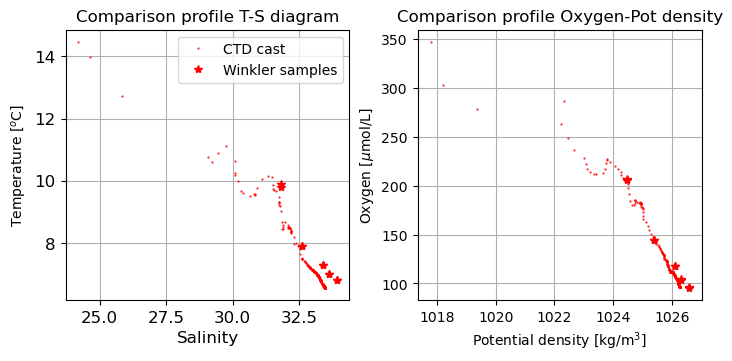

In [90]:
#Visualize the comparison profile
fig, ax = plt.subplots(1,2,constrained_layout=True, 
                            figsize=(7, 3.5))

ax[0].plot(SH,TH,'r.', markersize=1, label='CTD cast')
ax[0].plot(SH2,TH2,'*r', label='Winkler samples')
ax[0].grid()
ax[0].set_title('Comparison profile T-S diagram')
ax[0].set_xlabel('Salinity',fontsize=12)
ax[0].set_ylabel('Temperature [$^o$C]')
ax[0].tick_params(labelsize=12)
ax[0].legend()

ax[1].plot(RH0,OH,'r.', markersize=1)
ax[1].plot(RH02,OH2,'*r')
ax[1].grid()
ax[1].set_title('Comparison profile Oxygen-Pot density')
ax[1].set_xlabel('Potential density [kg/m$^3$]')
ax[1].set_ylabel('Oxygen [$\mu$mol/L]')
ax[1].tick_params()

print('Temperature vs salinity, and oxygen vs potential density for the bottle and CTD cast samples:')

We see good agreement between the comparison profile from the oxygen sensor used during the CTD cast and the Winkler bottle samples, with the exception of the densest, deepest water. For the deepest Winkler sample, it appears that the bottle salinity is quite different from that measured by the CTD, which affects the oxygen agreement in potential density space as well. We now compare to the available glider data.

In [91]:
# Compare to closest time and location
# Find closest glider profiles in time and space 

# Set a depth cutoff based on the depth of the comparison profile
zmax = 250 #Glider profile must extend deeper than this for comparison
print(f'Using minimum depth of: {zmax}')

# Set up glider fields for comparison
OO = oxygen_correct
dens = ds.longitude.copy()*np.nan
dens[:] = seawater.eos80.dens(ds.salinity, ds.temperature, ds.pressure)
dens0 = seawater.eos80.dens0(ds.salinity, ds.temperature)
lon = ds.longitude.values
lat = ds.latitude.values

#Calculate the distance between the comparison profile and each ocean glider profile
dist = np.empty_like(ds.longitude.values)*np.nan
p_ind = np.unique(ds.profile_index)
for i, p in enumerate(p_ind[p_ind>0]):
    if ~np.isnan(p):
        dist[ds.profile_index.values==p] = seawater.dist([np.nanmean(lon[ds.profile_index.values==p]), lonH], 
                                                         [np.nanmean(lat[ds.profile_index.values==p]), latH], units='km')[0][0]
        if np.nanmax(ds.depth[ds.profile_index.values==p])<zmax:
            dist[ds.profile_index.values==p] = dist[ds.profile_index.values==p]*np.nan
            
#Store fields in a new xarray for comparison 
ds_tmp = ds.copy(deep=True)
ds_tmp['dist'] = ('time', dist)
ds_tmp['oxy_cor'] = oxygen_correct
ds_tmp['dens'] = dens
ds_tmp['dens0'] = ('time', dens0)

Using minimum depth of: 250


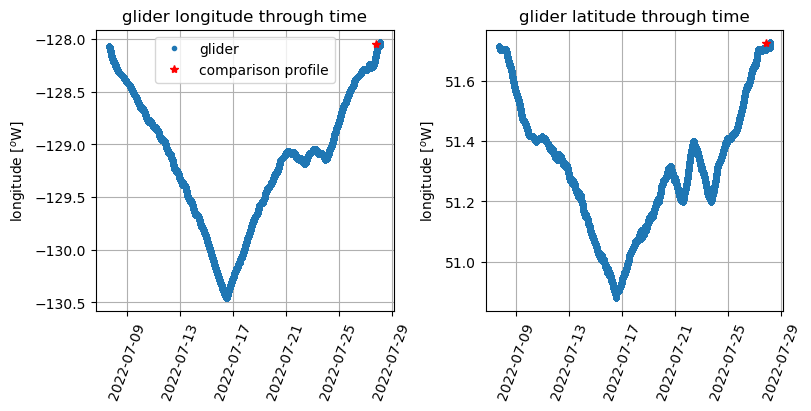

In [92]:
fig, ax = plt.subplots(1,2,constrained_layout=True, 
                            figsize=(8, 4))

ax[0].plot(ds.time,ds.longitude,'.',label='glider')
ax[0].plot(pd.to_datetime(timeH),lonH,'r*',label='comparison profile')
ax[0].grid()
ax[0].set_title('glider longitude through time')
ax[0].tick_params(axis='x',rotation=70)
# ax[0].set_xlabel('Date')
ax[0].set_ylabel('longitude [$^o$W]')
ax[0].tick_params()
ax[0].legend()

ax[1].plot(ds.time,ds.latitude,'.')
ax[1].plot(pd.to_datetime(timeH),latH,'r*')
ax[1].grid()
ax[1].set_title('glider latitude through time')
ax[1].tick_params(axis='x',rotation=70)
# ax[1].set_xlabel('Date')
ax[1].set_ylabel('longitude [$^o$W]')
ax[1].tick_params()

In [93]:
#Pull out a small amount of glider data for comparison
min_dist = 0.5 # This is how close the profile must be in km
min_time = 1 # 2 x min_time is how close the profile must be in days
print("****")
print(f'Glider must be within {min_dist} km')
print(f'Profile must be within {min_time} day(s) of sample')
print('****')

dist_tmp = ds_tmp.where(ds_tmp.dist<(ds_tmp.dist.min(skipna=True)+min_dist))
time_lower = pd.to_datetime(timeH) - timedelta(days=min_time)
time_upper = pd.to_datetime(timeH) + timedelta(days=min_time)

tmp_sub = dist_tmp.sel(time=slice(time_lower,time_upper))
valid_idxs = np.unique(tmp_sub.profile_index)[np.isfinite(np.unique(tmp_sub.profile_index))]

print('Number of glider profiles available for comparison: ', len(valid_idxs))
print('Profile indices of profile(s) available for comparison: ', valid_idxs)

****
Glider must be within 0.5 km
Profile must be within 1 day(s) of sample
****
Number of glider profiles available for comparison:  1
Profile indices of profile(s) available for comparison:  [893.]


In [94]:
PROFILE_USE = valid_idxs[0]
# PROFILE_USE = 892

In [95]:
#Plotting the coordinates
ind = tmp_sub.profile_index == PROFILE_USE

lon_fin = tmp_sub.longitude.values[ind]
print(lon_fin)
lat_fin = tmp_sub.latitude.values[ind]

[-128.05360833 -128.05360666 -128.05360498 ... -128.0444552  -128.04445629
 -128.04445737]


Top: latitude and longitude of glider profiles, with the comparison profiles and chosen profile indicated. Bottom left: Oxygen from glider profile (black) shown with CTD (red points) and bottle (red stars) samples. Bottom right: Potential density vs oxgen for the glider profile and sample data from CTD and bottles.


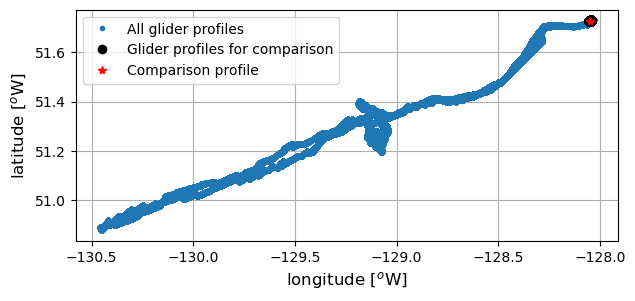

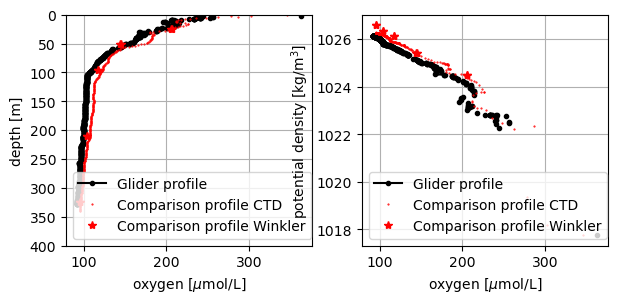

In [99]:

plt.figure(figsize=(7,3))
plt.plot(lon, lat, '.', label='All glider profiles')
plt.plot(lon_fin, lat_fin, 'ok', label='Glider profiles for comparison')
plt.plot(lonH, latH, 'r*', label='Comparison profile')
plt.ylabel('latitude [$^o$W]',fontsize=12)
plt.xlabel('longitude [$^o$W]',fontsize=12)
plt.legend()
plt.grid()

# Plotting the data
fig, axs = plt.subplots(1, 2, figsize=(7,3))

axs[0].plot(tmp_sub.oxy_cor.values[ind], tmp_sub.depth.values[ind], 'k.-', label='Glider profile')
axs[0].plot(OH, depthH, 'r.', markersize=1, label='Comparison profile CTD')
axs[0].plot(OH2, depthH2, 'r*', label='Comparison profile Winkler')
axs[0].set_ylim(400,0)
axs[0].set_ylabel('depth [m]')
axs[0].set_xlabel('oxygen [$\mu$mol/L]')
axs[0].grid()
axs[0].legend();

axs[1].plot(tmp_sub.oxy_cor.values[ind], tmp_sub.dens0.values[ind], 'k.-', label='Glider profile')
axs[1].plot(OH, RH0, 'r.', markersize=1, label='Comparison profile CTD')
axs[1].plot(OH2, RH02, 'r*', label='Comparison profile Winkler')
# axs[1].set_ylim(1020,1027)
axs[1].set_ylabel('potential density [kg/m$^3$]')
axs[1].set_xlabel('oxygen [$\mu$mol/L]')
axs[1].grid()
axs[1].legend();

print('Top: latitude and longitude of glider profiles, with the comparison profiles and chosen profile indicated. Bottom left: Oxygen from glider profile (black) shown with CTD (red points) and bottle (red stars) samples. Bottom right: Potential density vs oxgen for the glider profile and sample data from CTD and bottles.')

The comparison profile was collected at the time of glider recovery, during the final glider profile, and includes high-quality Winkler-titrated bottle samples as well as the profile collected by the oxygen sensor attached to the CTD. Given the agreement between the Winkler samples and the oxygen from the CTD profile, and given the small number of Winkler samples available for comparison, we determine the correction to the glider using the oxygen sensor data. 

We compare to the last full-depth glider profile collected, and determine the comparison using all available data, not restricting the densities. There is a slight offset from the glider oxygen profile visible in density space, which is what we expect to correct.

In [100]:
#Select desired glider profile for comparison
prof_ind = ind #index of the profile you want
tmp_sub = tmp_sub.where(prof_ind)

#Set up your density limits and bins
rho_low = 1020
rho_high = 1027
print(f'Using densities between {rho_low} and {rho_high}')

#Choose cutoff densities and apply to comparison profile
rho_cut = np.logical_and(RH0>=rho_low, RH0<=rho_high)
rbin = RH0[rho_cut] #potential density
obin = np.array(OH)[rho_cut]

#Bin glider data to bottle data densities with a tolerance of +/-tol kg/m3
tol = 0.2 #tolerance (as small as possible while avoiding gaps)
RRr = np.nan * np.zeros((len(rbin),)) #potential density
OOr = np.nan * np.zeros((len(rbin),))
PPr = np.nan * np.zeros((len(rbin),))

for j in range(len(rbin)):
    RRr[j] = np.nanmean(tmp_sub.dens0[np.logical_and(tmp_sub.dens0>=(rbin[j]-tol), tmp_sub.dens0<(rbin[j]+tol))])
    OOr[j] = np.nanmean(tmp_sub.oxy_cor[np.logical_and(tmp_sub.dens0>=(rbin[j]-tol), tmp_sub.dens0<(rbin[j]+tol))])
    PPr[j] = np.nanmean(tmp_sub.pressure[np.logical_and(tmp_sub.dens0>=(rbin[j]-tol), tmp_sub.dens0<(rbin[j]+tol))])

#Set up the fields to compare, converting to umol/kg using potential density
fldg = (OOr/RRr*1000) #Glider profile
fldH = (obin/rbin*1000) #Comparison profile
# RRr is the density field I want


Using densities between 1020 and 1027


Binned and unbinned oxygen collected by the CTD, plotted against potential density (left). Potential density vs oxygen also shown for the binned and unbinned glider profile (right).


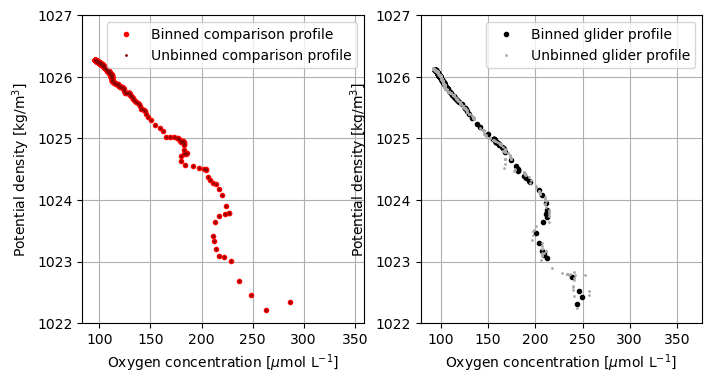

In [102]:
# Check that the binning worked properly
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(obin, rbin, 'r.', label='Binned comparison profile')
axs[0].plot(OH, RH0, '.', color='darkred', 
            markersize=2, label='Unbinned comparison profile')
axs[0].set_ylabel('Potential density [kg/m$^3$]') 
axs[0].set_xlabel('Oxygen concentration [$\mu$mol L$^{-1}$]')
axs[0].set_ylim(1022,1027) 
axs[0].grid()
axs[0].legend()

axs[1].plot(OOr, RRr, 'k.', label='Binned glider profile')
axs[1].plot(tmp_sub.oxy_cor.values[ind], tmp_sub.dens0.values[ind], '.', 
            color='darkgray', markersize=2, label='Unbinned glider profile')
axs[1].set_ylabel('Potential density [kg/m$^3$]') 
axs[1].set_xlabel('Oxygen concentration [$\mu$mol L$^{-1}$]')
axs[1].set_ylim(1022,1027) 
axs[1].grid()
axs[1].legend();
print('Binned and unbinned oxygen collected by the CTD, plotted against potential density (left). Potential density vs oxygen also shown for the binned and unbinned glider profile (right).')

Potential density vs oxygen concentration for the binned glider and CTD profiles (left). Oxygen from the CTD vs oxygen from the glider profile (right).


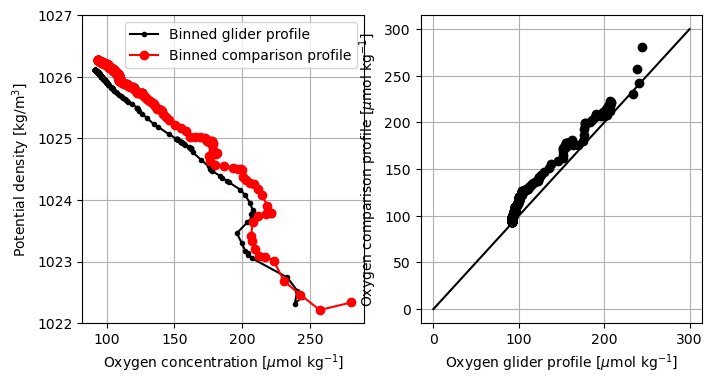

In [104]:
# Plotting the data
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(fldg, RRr, 'k.-', label='Binned glider profile')
axs[0].plot(fldH, rbin, 'ro-', label='Binned comparison profile')
axs[0].set_ylabel('Potential density [kg/m$^3$]') 
axs[0].set_xlabel('Oxygen concentration [$\mu$mol kg$^{-1}$]')
axs[0].set_ylim(1022,1027) 
axs[0].grid()
axs[0].legend()

axs[1].plot(fldg, fldH, 'ko')
axs[1].plot((0, 300), (0, 300), 'k-')
axs[1].set_ylabel('Oxygen comparison profile [$\mu$mol kg$^{-1}$]') 
axs[1].set_xlabel('Oxygen glider profile [$\mu$mol kg$^{-1}$]')
axs[1].grid()
print('Potential density vs oxygen concentration for the binned glider and CTD profiles (left). Oxygen from the CTD vs oxygen from the glider profile (right).')

We now apply a least-squares fit between the two profiles in isopycnal space. We force the intercept to pass through zero, as this has been demonstrated to result in more accurate corrections. As oxygen optodes drift, they tend to read lower values of oxygen [Bittig et al., 2015], so we expect the correction to produce a slight increase in oxygen concentration. 

In [105]:
# Forcing the intercept to go through ZERO
intercept_zero = True
if intercept_zero:
    mask = ~np.isnan(fldg) & ~np.isnan(fldH)
    p_zero = np.linalg.lstsq(fldg[mask].reshape(-1,1), fldH[mask], rcond=None)[0]
    x = np.arange(50, 300, 1) #Used for plotting
    Y = np.polyval([p_zero[0], 0], x)
    slope,intercept,R_val,p_val,stn_err = stats.linregress(fldg[mask], fldH[mask])

    print(f"slope m = {np.round(p_zero,4)} and R2 = {np.round(R_val**2,2)}")
    print(f"p: {round(p_val,4)}, stnerr: {round(stn_err,4)}, intercept: {round(intercept,3)}")

slope m = [1.097] and R2 = 0.97
p: 0.0, stnerr: 0.0096, intercept: 3.518


## 2.5 Optode drift correction 
**Sanity checks:**

We now apply our drift correction and confirm that the drift correction has had the intended effect. We check the following:
1. Do we see better agreement with the full comparison profile, particularly in the deep water and at the surface?
2. Are values at the surface consistent with saturated (or over-satured) water?
3. Are values at 1000 m consistent with other deep oxygen samples or at least reasonable?


Applied slope of 1.097
Oxygen from the CTD profile vs glider oxygen, shown before (black) and after (red) applying a linear correction:


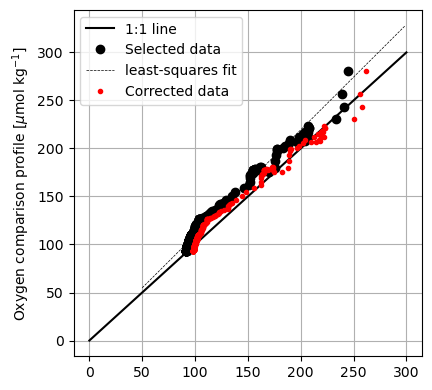

In [108]:
# Plotting the best fit line
mask = ~np.isnan(fldg) & ~np.isnan(fldH)
corrvals = (fldg / RRr * 1000) * p_zero[0]
maskcorr = ~np.isnan(corrvals) & ~np.isnan(fldH)
p_zerocorr = np.linalg.lstsq(corrvals[maskcorr].reshape(-1,1), fldH[maskcorr], rcond=None)[0]

plt.figure(figsize = (4.5,4.5))
plt.plot((0, 300), (0, 300), 'k-', label = "1:1 line")
plt.plot(fldg, fldH, 'ko', label='Selected data')
plt.plot(x, Y, 'k-', linewidth=0.5, label='least-squares fit', linestyle = 'dashed')
plt.plot(corrvals, fldH, '.', label = 'Corrected data', color = 'red')
plt.ylabel('Oxygen comparison profile [$\mu$mol kg$^{-1}$]')
plt.grid()
plt.legend()

print(f"Applied slope of {round(p_zero[0],4)}")
print('Oxygen from the CTD profile vs glider oxygen, shown before (black) and after (red) applying a linear correction:')

Glider oxygen before and after the linear correction:


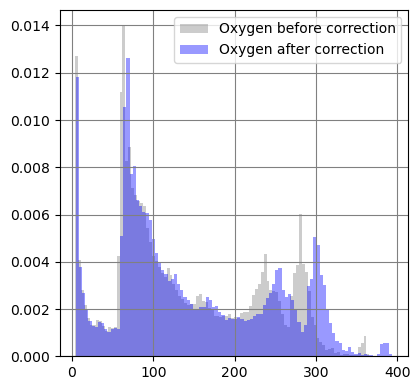

In [111]:
# Apply the drift correction
if intercept_zero:
    # Converting the units, then multiplying by the slope (p_zero[0]) 
    oxygen_drift = (oxygen_correct / dens0 * 1000) * p_zero[0] #UNITS = umol/kg!

    # Set any unphysical values to NaN
oxygen_drift[np.logical_or(oxygen_drift > 500, oxygen_drift<0)] = np.nan

plt.figure(figsize = (4.5,4.5))
plt.hist(oxygen_correct, 100, alpha = 0.4, density=True, histtype='bar', 
                  color='gray', label='Oxygen before correction')
plt.hist(oxygen_drift, 100, alpha = 0.4, density=True, histtype='bar', 
                  color='blue', label='Oxygen after correction')
plt.legend(prop={'size': 10})
plt.grid(color='0.5')
print('Glider oxygen before and after the linear correction:')

Potential density vs oxygen shown for the glider and sampled oxygen data before correction (left) and after correction applied to the glider profile (right):


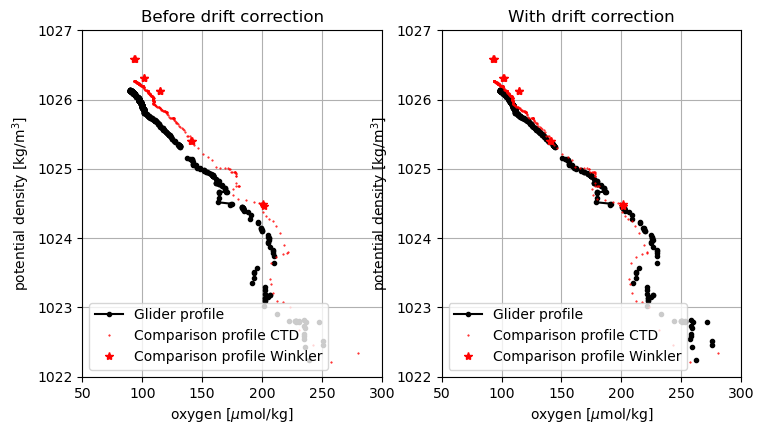

In [113]:
# Plotting the data without and with the drift comparison
fig, axs = plt.subplots(1, 2, figsize=(8.5,4.5))

axs[0].set_title('Before drift correction')
axs[0].plot(tmp_sub.oxy_cor.values / tmp_sub.dens0.values * 1000, tmp_sub.dens0.values, 'k.-', label='Glider profile')
axs[0].plot(OH / RH0 * 1000, RH0, 'r.', markersize=1, label='Comparison profile CTD')
axs[0].plot(OH2 / RH02 * 1000, RH02, 'r*', label='Comparison profile Winkler')
axs[0].set_ylim(1022,1027)
axs[0].set_xlim(50,300)
axs[0].set_ylabel('potential density [kg/m$^3$]')
axs[0].set_xlabel('oxygen [$\mu$mol/kg]')
axs[0].grid()
axs[0].legend()

axs[1].set_title('With drift correction')
axs[1].plot((tmp_sub.oxy_cor.values / tmp_sub.dens0.values * 1000) * p_zero[0], tmp_sub.dens0.values, 'k.-', label='Glider profile')
axs[1].plot(OH / RH0 * 1000, RH0, 'r.', markersize=1, label='Comparison profile CTD')
axs[1].plot(OH2 / RH02 * 1000, RH02, 'r*', label='Comparison profile Winkler')
axs[1].set_ylim(1022,1027)
axs[1].set_xlim(50,300)
axs[1].set_ylabel('potential density [kg/m$^3$]')
axs[1].set_xlabel('oxygen [$\mu$mol/kg]')
axs[1].grid()
axs[1].legend();
print('Potential density vs oxygen shown for the glider and sampled oxygen data before correction (left) and after correction applied to the glider profile (right):')

**Agreement with comparison profile**: The agreement with the comparison profile has improved significantly, except near the surface where there is high variability. 

In [114]:
def O2sol(S,T):
# O2sol   Solubility of O2 in sea water
#=========================================================================
# O2sol Version 1.1 4/4/2005 converted to Python by Hayley Dosser in 2023
# USAGE:  concO2 = O2sol(S,T)
# DESCRIPTION:
#    Solubility (saturation) of oxygen (O2) in sea water
#    at 1-atm pressure of air including saturated water vapor
# INPUT:  (if S and T are not singular they must have same dimensions)
#   S = salinity    [PSS]
#   T = temperature [degree C]
# OUTPUT:
#   concO2 = solubility of O2  [umol/kg]  
# AUTHOR:  Roberta Hamme (rhamme@ucsd.edu) in Matlab
# REFERENCE:
#    Hernan E. Garcia and Louis I. Gordon, 1992.
#    "Oxygen solubility in seawater: Better fitting equations"
#    Limnology and Oceanography, 37, pp. 1307-1312.
#=========================================================================

    # convert T to scaled temperature
    temp_S = np.log((298.15 - T)/(273.15 + T));

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A0_o2 = 5.80871; 
    A1_o2 = 3.20291;
    A2_o2 = 4.17887;
    A3_o2 = 5.10006;
    A4_o2 = -9.86643e-2;
    A5_o2 = 3.80369;
    B0_o2 = -7.01577e-3;
    B1_o2 = -7.70028e-3;
    B2_o2 = -1.13864e-2;
    B3_o2 = -9.51519e-3;
    C0_o2 = -2.75915e-7;

    # Corrected Eqn (8) of Garcia and Gordon 1992
    conc_O2 = np.exp(A0_o2 + A1_o2*temp_S + A2_o2*temp_S**2 + A3_o2*temp_S**3 + A4_o2*temp_S**4 + A5_o2*temp_S**5 + S*(B0_o2 + B1_o2*temp_S + B2_o2*temp_S**2 + B3_o2*temp_S**3) + C0_o2*S**2);

    return conc_O2

Depth vs oxygen concentration for the glider profile (black), CTD profile (red), and oxygen saturation (blue) both before (left) and after (right) the drift correction:


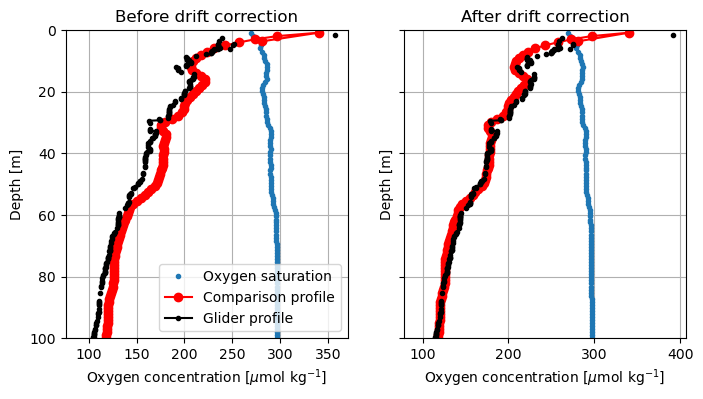

In [116]:
# Plotting the data without and with the drift comparison
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)

ax[0].set_title('Before drift correction')
ax[0].plot(O2sol(np.array(SH),np.array(TH)), depthH, '.', label='Oxygen saturation')
ax[0].plot(OH / RH0 * 1000, depthH, 'ro-', label='Comparison profile')
ax[0].plot(tmp_sub.oxy_cor.values / tmp_sub.dens0.values * 1000, tmp_sub.depth, 'k.-', label='Glider profile')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Oxygen concentration [$\mu$mol kg$^{-1}$]')
ax[0].set_ylim(100, 0)
ax[0].legend()
ax[0].grid()

ax[1].set_title('After drift correction')
ax[1].plot(O2sol(np.array(SH),np.array(TH)), depthH, '.', label='Oxygen saturation')
ax[1].plot(OH / RH0 * 1000, depthH, 'ro-', label='Comparison profile')
ax[1].plot((tmp_sub.oxy_cor.values / tmp_sub.dens0.values * 1000) * p_zero[0], tmp_sub.depth, 'k.-', label='Glider profile')
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Oxygen concentration [$\mu$mol kg$^{-1}$]')
# ax[1].set_ylim(20, 0)
ax[1].grid()

print('Depth vs oxygen concentration for the glider profile (black), CTD profile (red), and oxygen saturation (blue) both before (left) and after (right) the drift correction:')

**Surface values**: Both the glider profile and comparison profile appear over-saturated right at the surface. Before the drift correction, the glider is in decent agreement with the comparison profile below 5 m but less saturated above 5 m. After the correction, agreement below 5 m is not quite as good, but the glider profile is closer to 100% saturation above 5 m and matches to the comparison profile more closely. This type of surface comparison provides information, but is not conclusive, particularly in a dynamic environment such as Hakai Pass.


The minimum oxygen value before any oxygen corrections is 5.0 umol/kg
The minimum oxygen value before the drift correction is 4.22 umol/kg
The minimum oxygen value after the drift correction is 4.51 umol/kg
Glider oxygen shown at three stages: with no corrections applied (grey), directly before the drift correction with the compensations and other corrections applied (light blue), and directly following the linear correction using the sample data (dark blue):


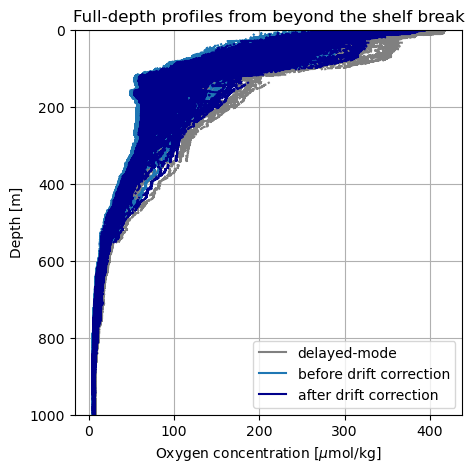

In [122]:
#Plotting full-depth profiles from beyond the shelfbreak
n0 = 348
n1 = 391

n0 = 0
n1 = np.nanmax(ds.profile_index)
indp = np.logical_and(ds.profile_index>=n0, ds.profile_index<=n1)

plt.figure(figsize = (5,5))
plt.plot(ds.oxygen_concentration[indp]/dens0[indp]*1000, 
         ds.depth[indp],'-',color='gray',label='delayed-mode', rasterized=True)
plt.plot(oxygen_correct[indp]/dens0[indp]*1000, 
         ds.depth[indp],'-',label='before drift correction', rasterized=True)
plt.plot(oxygen_drift[indp], 
         ds.depth[indp],'-',color = 'darkblue', label='after drift correction', rasterized=True)
plt.ylabel('Depth [m]')
plt.xlabel('Oxygen concentration [$\mu$mol/kg]')
# plt.ylim(1000, 150)
plt.ylim(1000,0)
# plt.xlim(0, 100)
plt.grid()
plt.legend()
plt.title('Full-depth profiles from beyond the shelf break')

print(f'The minimum oxygen value before any oxygen corrections is {np.round(np.nanmin(ds.oxygen_concentration[indp]/dens0[indp]*1000),2)} umol/kg')
print(f'The minimum oxygen value before the drift correction is {np.round(np.nanmin(oxygen_correct[indp]),2)} umol/kg')
print(f'The minimum oxygen value after the drift correction is {np.round(np.nanmin(oxygen_drift[indp]),2)} umol/kg')

print('Glider oxygen shown at three stages: with no corrections applied (grey), directly before the drift correction with the compensations and other corrections applied (light blue), and directly following the linear correction using the sample data (dark blue):')

**Comparison of deep oxygen**: There are no good DFO profiles from beyond the shelf break to compare with during the glider mission. However, we see that the drift correction has increased the deep oxygen values slightly. This is a good sanity check, since oxygen optode sensor drift tends to cause lower values. Furthermore, the change caused by the drift correction is smallest for the deep oxygen data, as expected. However, the oxygen has overall slightly decreased relative to the delayed-mode data, when considering all corrections performed here.

Change in oxygen concentration before and after corrections applied shown over time (left), and by concentration (right).


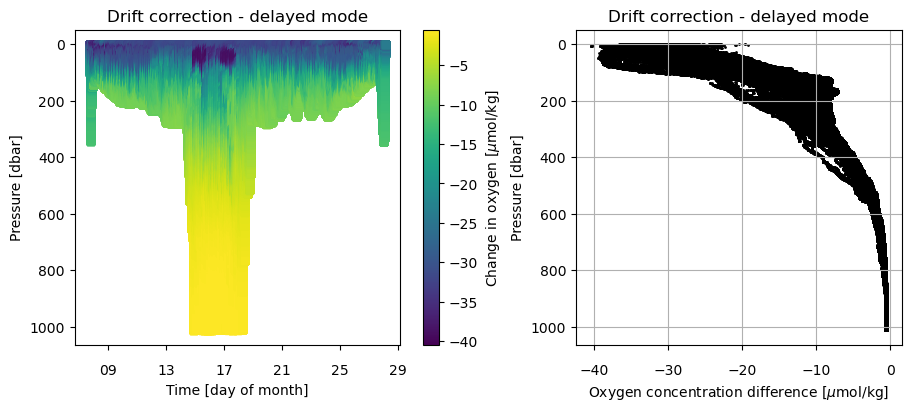

In [124]:
#Visualizing the drift correction
n0 = 348
n1 = 391

n0 = 0
n1 = np.nanmax(ds.profile_index)

indp = np.logical_and(ds.profile_index>=n0, ds.profile_index<=n1)
fld_orig = ds.oxygen_concentration[indp]/dens0[indp]*1000
dp = ds.pressure[indp]
tm = ds.time[indp]
fld = oxygen_drift[indp]
sal = ds.salinity[indp]

fig, ax = plt.subplots(1,2,constrained_layout=True, 
                            figsize=(9, 4))

ax1 = ax[0]
sc = ax1.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, 
                 c=fld[~np.isnan(fld)]-fld_orig[~np.isnan(fld)], marker='s', rasterized=True)#vmin=0.5, vmax=35)
cb1 = plt.colorbar(sc, ax=ax1, orientation='vertical',label='Change in oxygen [$\mu$mol/kg]')
cb1.ax.tick_params()
ax1.set_title('Drift correction - delayed mode')
ax1.set_xlabel('Time [day of month]')
ax1.set_ylabel('Pressure [dbar]')
ax1.invert_yaxis()
ax1.tick_params()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax1.xaxis.set_tick_params(which='major', pad=10)

ax2 = ax[1]
ax2.grid()
ax2.scatter(fld[~np.isnan(fld)]-fld_orig[~np.isnan(fld)], dp[~np.isnan(fld)],  s=1, c='k', rasterized=True)
ax2.set_title('Drift correction - delayed mode')
ax2.set_xlabel('Oxygen concentration difference [$\mu$mol/kg]')
ax2.set_ylabel('Pressure [dbar]')
ax2.invert_yaxis()
ax2.tick_params()
ax2.xaxis.set_tick_params(which='major', pad=10)

print('Change in oxygen concentration before and after corrections applied shown over time (left), and by concentration (right).')

# 3.0 Summary of corrections applied

Given the high-quality comparison profile, and the supporting evidence suggesting the estimated drift correction produces reasonable results, we choose to apply the drift correction. However, note that the optode on this glider was calibrated only 8 months before the mission, and the drift correction estimated is large.  

The change in oxygen concentration after applying the drift correction is between 0 and 10$\mu$mol/kg below 400m, and up to nearly 40$\mu$mol/kg at the surface. 


In [125]:
# Renamed oxygen_adjusted to oxygen

ds['oxygen'] = ds.oxygen_concentration.copy()
ds.oxygen.values = (oxygen_drift/1000) * dens0
ds['oxygen'].attrs['units'] = 'umol L-1'
ds['oxygen'].attrs['comment'] = 'Corrected oxygen concentration'
# ds['oxygen'].attrs['processing_report'] = processing_report
ds['oxygen'].attrs['processing_date'] = processing_date
ds['oxygen'].attrs['processing_protocol'] = processing_protocol

# Now rename the "old" uncorrected oxygen
ds['oxygen0'] = ds.oxygen_concentration.copy()
ds.oxygen0.values = ds.oxygen_concentration.values
ds['oxygen0'].attrs['units'] = 'umol L-1'
ds['oxygen0'].attrs['comment'] = 'Uncorrected oxygen concentration'
# ds['oxygen0'].attrs['processing_report'] = processing_report
ds['oxygen0'].attrs['processing_date'] = processing_date
ds['oxygen0'].attrs['processing_protocol'] = processing_protocol

In [126]:
# GET RID OF OLD FIELDS!!!
ds = ds.drop_vars('oxygen_concentration')

In [127]:
ds.to_netcdf(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_corrected_v2.nc')
print(f'Corrected data saved to file: {filepath}/{glider_name}/{deploy_name}/{deploy_name}_corrected_v2.nc')

Corrected data saved to file: e:/Glider/data//dfo-bb046/dfo-bb046-20220707/dfo-bb046-20220707_corrected_v2.nc


In [128]:
import pyglider.ncprocess as ncprocess
ncprocess.make_gridfiles(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_corrected_v2.nc',
                         f'{filepath}/{glider_name}/{deploy_name}', 
                         deployfile, 
                         fnamesuffix='_corrected_v2')
print(f'Gridfile created: {filepath}/{glider_name}/{deploy_name}/{deploy_name}_grid_corrected_v2.nc')

Gridfile created: e:/Glider/data//dfo-bb046/dfo-bb046-20220707/dfo-bb046-20220707_grid_corrected_v2.nc


The corrected salinity and temperature, shown with filtered conductivity and corrected oxygen:


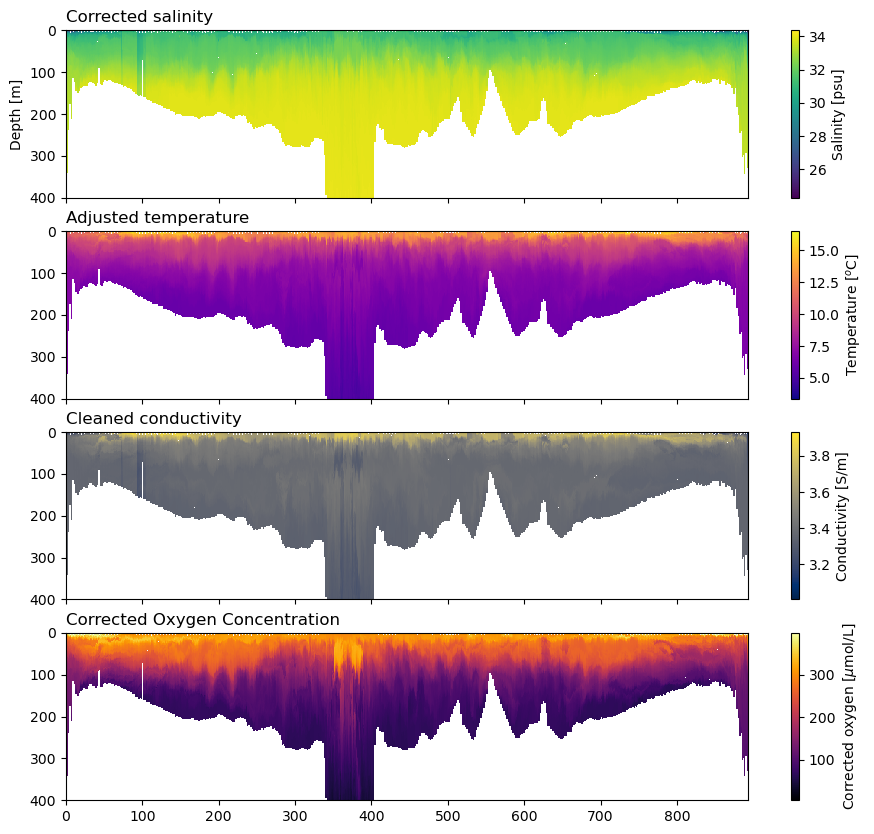

In [129]:
# Open the grid file
ds=xr.open_dataset(f'{filepath}/{glider_name}/{deploy_name}/{deploy_name}_grid_corrected_v2.nc')
# list(ds.keys())

# RE-PLOTTING WITH THE COND FILTER!
fig, axs = plt.subplots(4, 1, figsize=(11, 10), sharey=True, sharex=True)

xlims = [0, np.nanmax(ds.profile_index)]
# xlims=[0,100]
# xlims = [880,894]

ylims=[400,0]
pc = axs[0 ].pcolormesh(ds.profile, ds.depth, ds['salinity'],rasterized=True)
axs[0].set_ylim(ylims)
axs[0].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0], label = 'Salinity [psu]')
axs[0].set_ylabel('Depth [m]')
axs[0].set_title('Corrected salinity',loc='left')

pc = axs[1].pcolormesh(ds.profile, ds.depth, ds['temperature'],rasterized=True,cmap='plasma')
axs[1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[1], label = 'Temperature [$^o$C]')
axs[1].set_title('Adjusted temperature',loc='left')

# from matplotlib import colors as c
# pc = axs[2].pcolormesh(ds.profile, ds.depth, ds['conductivity'],rasterized=True,cmap=c.ListedColormap(['r']))
pc = axs[2].pcolormesh(ds.profile, ds.depth, ds['conductivity'],rasterized=True,cmap='cividis')
axs[2].set_xlim(xlims)
fig.colorbar(pc, ax=axs[2], label = 'Conductivity [S/m]')
axs[2].set_title('Cleaned conductivity',loc='left')

pc = axs[3].pcolormesh(ds.profile, ds.depth, ds['oxygen'],rasterized=True,cmap='inferno')
axs[3].set_xlim(xlims)
fig.colorbar(pc, ax=axs[3], label = 'Corrected oxygen [$\mu$mol/L]')
axs[3].set_title('Corrected Oxygen Concentration',loc='left')

print('The corrected salinity and temperature, shown with filtered conductivity and corrected oxygen:')

The delayed-mode oxygen, corrected oxygen, and difference between the two. The red star indicates the profile used for comparison with sample data:


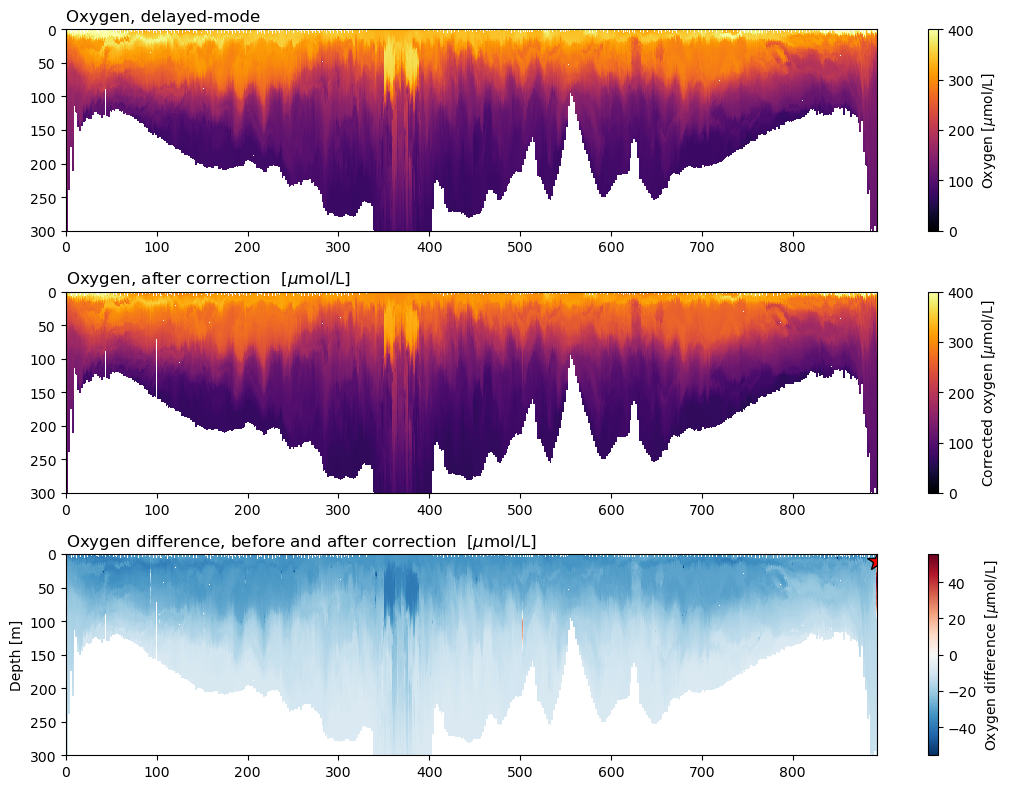

In [130]:
# RE-PLOTTING WITH THE COND FILTER!
fig, axs = plt.subplots(3, 1, figsize=(11, 8), sharey=True,  squeeze=True)

# Limits
xlims = [0, np.nanmax(ds.profile_index)]
ylims=[300,0]
t_lims = [0,400]
# xlims=[880,895]

axs[2].set_ylabel('Depth [m]')
axs[0].set_title('Oxygen, delayed-mode',loc='left')
axs[1].set_title('Oxygen, after correction  [$\mu$mol/L]',loc='left')
axs[2].set_title('Oxygen difference, before and after correction  [$\mu$mol/L]',loc='left')

# # Subplots from correction area

# Subplot from correction area
pc = axs[0].pcolormesh(ds.profile, ds.depth, ds['oxygen0'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], cmap='inferno')
axs[0].set_ylim(ylims)
axs[0].set_xlim(xlims)
fig.colorbar(pc, ax=axs[0], label = "Oxygen [$\mu$mol/L]")

pc = axs[1].pcolormesh(ds.profile, ds.depth, ds['oxygen'],rasterized=True,vmin=t_lims[0], vmax=t_lims[1], cmap='inferno')
axs[1].set_ylim(ylims)
axs[1].set_xlim(xlims)
fig.colorbar(pc, ax=axs[1], label = "Corrected oxygen [$\mu$mol/L]")

maxdiff = abs(np.nanmax(ds['oxygen']-ds['oxygen0']))
difflims = [maxdiff*-1, maxdiff]
pc = axs[2].pcolormesh(ds.profile, ds.depth, ds['oxygen']-ds['oxygen0'],cmap='RdBu_r',
                      vmin=difflims[0], vmax=difflims[1], rasterized = True)
axs[2].set_ylim(ylims)
axs[2].set_xlim(xlims)
fig.colorbar(pc, ax=axs[2], label = "Oxygen difference [$\mu$mol/L]")
fig.tight_layout()

x = 893
y = 10
axs[2].plot(x,y,'k*',markerfacecolor='r',markersize=15, zorder=2);

print('The delayed-mode oxygen, corrected oxygen, and difference between the two. The red star indicates the profile used for comparison with sample data:')

Overall, the oxygen declined relative to the delayed-mode data when all conversions and adjustments were applied, though we can see a few profiles that increased. These may require further steps to examine further if the data is valid.

In [131]:
display(Markdown('./docs/OXY_References.md'))

# References

1.	AANDERAA TD 269, ‘OPERATING MANUAL OXYGEN OPTODE 4330, 4831, 4835’. June 2017. Aanderaa Data Instruments AS

2.	RINKO A-0133-05, ‘Rinko Fast optical DO sensor for integration RINKO FT (Model name: ARO-FT, AROD-FT) User’s Manual’. JFE Advantech Co., Ltd.

3.	Uchida H., Kawano, T., Kaneko, I., and Fukasawa, M., ‘In-situ calibration of optode-based oxygen sensors’. 2008. Journal of Atmospheric and Oceanic Technology, 25: 2271-2281.

4.	Uchida, H. Johnson, G.,C. and McTaggart, G,. C., ‘CTD Oxygen Sensor Calibration Procedures’. In, The GO-SHIP Repeat Hydrography Manual: A Collection of Expert Reports and Guidelines.  2010. Version 1, (eds Hood, E.M., C.L. Sabine, and B.M. Sloyan), 17pp. (IOCCP Report Number 14; ICPO Publication Series Number 134). DOI: https://doi.org/10.25607/OBP-1344.

5.	Bittig, H. C., Fiedler, B., Scholz, R., Krahmann, G., Körtzinger, A., ‘Time response of oxygen optodes on profiling platforms and its dependence on flow speed and temperature’. 2014. Limnology and Oceanography: Methods, 12. DOI: 10.4319/lom.2014.12.617.

6.	Howatt, T., Palter, J. B., Matthews, R., deYoung, B., Bachmayer, R. and Claus, B., ‘Ekman and Eddy Exchange of Freshwater and Oxygen across the Labrador Shelf Break’. 2018. J. Phys. Oceanogr., 48, 1015–1031. DOI: 10.1175/JPO-D-17-0148.1.

7.	Nicholson, D., Emerson, S. and Eriksen, C. C., ‘Net community production in the deep euphotic zone of the subtropical North Pacific gyre from glider surveys’. 2008. Limnol. Oceanogr., 53, 2226–2236. DOI: 10.4319/lo.2008.53.5_part_2.2226.

8.	Fofonoff, N. P., Hayes, S. P. and Millard Jr., R. C., ‘W.H.O.I./Brown CTD microprofiler: Methods of calibration and data handling’. 1974. Woods Hole Oceanographic Institution Tech. Rep. WHOI-74-89, 64 pp. DOI: 10.1575/1912/647.

9.	Miloshevich, L. M., Paukkunen, A., Vömel, H., and Oltmans, S. J., ‘Development and Validation of a Time-Lag Correction for Vaisala Radiosonde Humidity Measurements’. 2004. J. Atmos. Oceanic Tech., 21, 1305–1327. DOI: 10.1175/1520-0426(2004)021<1305:DAVOAT>2.0.CO;2.

10.	Bittig, H. C., Körtzinger, A., Neill, C., Van Ooijen, E., Plant, J. N., Hahn, J., Johnson, K. S., Yang, B. and Emerson, S. R., ‘Oxygen optode sensors: principle, characterization, calibration, and application in the ocean’. 2019. Frontiers in Marine Science, 4, p.429.

